<h2>Creating New Meshwork Files</h2>
<div style="border-left: padding-left: 1px; background:#fbfcf9 " >
    
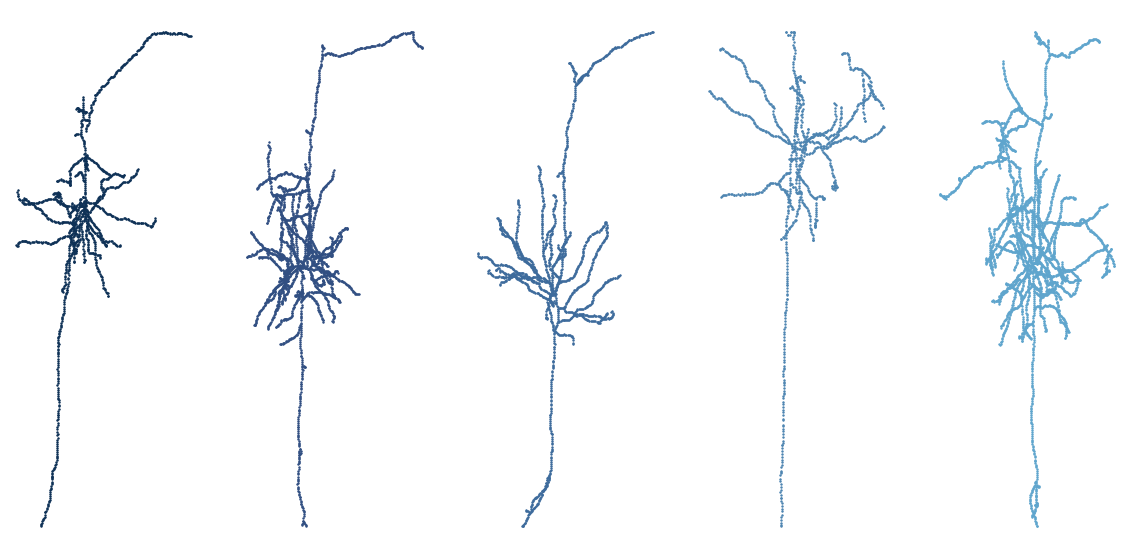

<div style="border-left: padding-left: 1px; background:#fbfcf9 " >
<h2>Creating New Meshwork Files</h2>

You may want to create your own meshwork files on neurons that are not included in the s3 bucket. This notebook will show you examples on how to 
- create a meshwork using different arguments 
- apply annotations to the meshwork (in this case, synapses)
- visualise the skeleton with annotations 
- export the meshwork 

<h3> Prerequisites:</h3>
To run this notebook please be sure to have pcg_skel (<code>pip install pcg_skel</code>) installed.

<div style="border-left: padding-left: 1px; background:#fbfcf9 " >
<h2>Basic Imports</h2>

In [1]:
from meshparty import meshwork
import pcg_skel
import matplotlib.pyplot as plt
from caveclient import CAVEclient

# This function will make it easy to check our work as we go.
def simple_neuron_plot(nrn, projection='xy', color='k', vertices='skeleton', synapses=False, highlight_root=False):
    """
    Parameters:
    nrn : meshwork object
    projection : one of "xy", "yz", or "zx" determining which projection to show in the simple plot
    color : matplotlib-accepted color value
    vertices : one of "skeleton" or "mesh" to determine which values are shown. Skeleton is default.
    synapses : True to show both pre and post, False to show neither, and "pre" or "post" to show only pre or post respectively.
    highlight_root : boolean. True if you want to show the root vertices with a big red dot.
    """
    if projection=='xy' or projection=="yx":
        ind1 = 0
        ind2 = 1
        flip = True
    elif projection == 'yz' or projection == "zy":
        ind1 = 2
        ind2 = 1
        flip = True
    elif projection == 'zx' or projection == "xz":
        ind1 = 0
        ind2 = 2
        flip = False
    else:
        raise ValueError('Projection must be one of "xy", "yz", or "zx"')
        
    fig, ax = plt.subplots(figsize=(4,4), dpi=150)
    if vertices == "skeleton":
        v1 = nrn.skeleton.vertices[:,ind1]
        v2 = nrn.skeleton.vertices[:,ind2]
        rid = nrn.skeleton.root
    elif vertices == "mesh":
        v1 = nrn.mesh.vertices[:,ind1]
        v2 = nrn.mesh.vertices[:,ind2]
        rid = nrn.root_region
    else:
        raise ValueError('vertices must be one of "skeleton" or "mesh"')

    ax.scatter(
        v1,
        v2,
        s=1,
        color=color,
    )
    
        
    if synapses:
        try:
            v1_pre = nrn.anno.pre_syn.points[:,ind1]
            v2_pre = nrn.anno.pre_syn.points[:,ind2]
            v1_post = nrn.anno.post_syn.points[:,ind1]
            v2_post = nrn.anno.post_syn.points[:,ind2]
        except:
            v1_pre = []
            v1_post = []
            v2_pre = []
            v2_post = []
        if synapses == True or synapses == 'pre':
            ax.scatter(
                v1_pre,
                v2_pre,
                s=2,
                color='tomato',
                alpha=0.7,
            )
        if synapses == True or synapses == "post":
            ax.scatter(
                v1_post,
                v2_post,
                s=2,
                color='turquoise',
                alpha=0.2,
            )
            
    if highlight_root:
        ax.scatter(
            v1[rid],
            v2[rid],
            s=25,
            color='violet',
        )

    ax.set_aspect('equal')
    if flip:
        ax.invert_yaxis()
    return fig, ax


<div style="border-left: padding-left: 1px; background:#fbfcf9 " >
<h2> Selecting Neurons </h2>
to create a meshwork of a neuron, you will need to have said neuron's root id.
<h4>This Example: Selecting Bipolar cells</h4>
we are going to run through how we would pick out neurons of a specific cell type from the 'allen_v1_column_types_slanted' table and get their root ids
    
Here, we are going to use the CAVEclient (Connectome Annotation Versioning Engine) to find the root ids of Bipolar Cells. 

<div style="border-left: padding-left: 1px; background:#fbfcf9 " >
<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec; ">
<h2>1. Set up Caveclient</h2>
CAVEclient is out proofrading/data annotation tool for largescale connectomics data
<br />First we set up caveclient so we can 'allen_v1_column_types_slanted' for our neurons of interest
<br>See https://github.com/seung-lab/CAVEclient for more information on CAVEclient<br />

In [2]:
datastack_name = 'minnie65_public_v343' 
client = CAVEclient(datastack_name)
client.materialize.version = 343

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec; ">
we want to pick Bipolar neurons from the highly-proofread column, so we can query the 'allen_v1_column_types_slanted' table which contains all the cells in the slanted column and their predicted cell type

In [3]:
print(client.materialize.get_tables()) # show all the tables availible to be queried 
column_type_df = client.materialize.query_table('allen_v1_column_types_slanted')
column_type_df.head(3)


['synapses_pni_2', 'nucleus_neuron_svm', 'nucleus_detection_v0', 'functional_coreg', 'allen_v1_column_types_slanted', 'aibs_column_nonneuronal', 'func_unit_em_match_release', 'proofreading_status_public_release', 'aibs_soma_nuc_metamodel_preds_v117']


,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,1379,t,aibs_coarse_excitatory,4P,89242892866409455,864691135687112672,"[178160, 175136, 21428]"
1,1382,t,aibs_coarse_excitatory,5P-IT,89594805373727621,864691135162584621,"[180624, 175696, 21782]"
2,1383,t,aibs_coarse_excitatory,5P-IT,91142986263977276,864691135988284416,"[191776, 175824, 20404]"


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec; ">
get familiar with the naming convention for cells in this table by looking at the unique entries in the 'cell_type' column
<br />'BPC' is Bipolar cells. Ask an instructor if you are not sure about your cell type of interest 

In [4]:
column_type_df['cell_type'].unique()

array(['4P', '5P-IT', '23P', 'Unsure E', 'BC', 'NGC', 'BPC', 'MC',
       '6P-IT', '5P-PT', '6P-U', 'Unsure', '5P-NP', '6P-CT', 'WM-P',
       'Unsure I'], dtype=object)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec; ">
We can create a new dataframe that just contains cells of predicted type 'BPC' 
<br />We can also pull out a list of the root ids of the BPCs 

In [5]:
bpc_df = column_type_df[column_type_df['cell_type']=='BPC'].reset_index(drop = True)
bpc_root_ids = bpc_df['pt_root_id'].values
len(bpc_root_ids)

33

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec; ">
<h2>2. Create a Meshwork object</h2>
We can use our root id list to create simple meshwork objects
<br />At a minimum, we need a root id and a CAVEclient in order to produce a skeleton.
While there are several functions in pcg_skel to create meshwork objects, the best one to use for this dataset is <code>coord_space_meshwork</code>.
You shouldn't need to use other functions for this course.

In [6]:
root_id = bpc_root_ids[5]

bpc_mw = pcg_skel.coord_space_meshwork(
    root_id=root_id,
    client=client
)

/opt/anaconda3/envs/friday-harbor/lib/python3.10/site-packages/caveclient/l2cache.py:78: UserWarning: L2Cache is in an experimental stage
  warnings.warn("L2Cache is in an experimental stage", UserWarning)
100%|█████████████████████████████████████████████████████████| 4132/4132 [00:00<00:00, 12899.32it/s]


(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

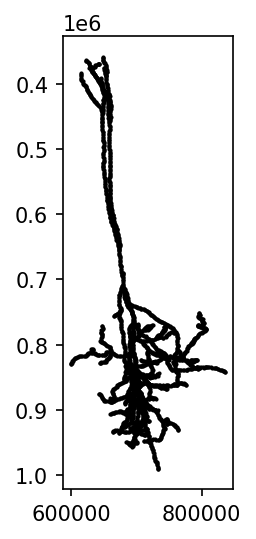

In [7]:
simple_neuron_plot(bpc_mw)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec; ">

However, you will notice that the root location isn't actually where you would expect it, at the cell body. See the magenta dot below.

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

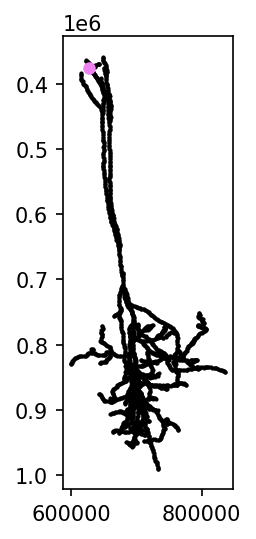

In [8]:
simple_neuron_plot(bpc_mw, highlight_root=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec; ">

You also won't see any additional annotations, like in the pre-computed files:

In [9]:
bpc_mw.anno

Data tables: ['lvl2_ids']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec; ">
    <h2>Building a meshwork with additional properties</h2>
   
The <code>coord_space_meshwork</code> has a number of parameters which allow us to create a richer file, for example with the root at the cell body and synapses added to the data. Here, we'll cover the ones that you might want to use here.

<table style="float: left; background-color: #acc68c">
    <tr>
        <td><h2>Parameter</h2></td>
        <td><h2>Description</h2></td>
    </tr> 
    <tr>
        <td>root_id</td>
        <td>Root id of the neuron to skeletonize</td>
    </tr>
    <tr>
        <td>client</td>
        <td>A caveclient initialized with the `minnie_public_v343` datastack, as above</td>
    </tr>
    <tr>
        <td>root_point</td>
        <td>If specified, the closest vertex to this point will be set as root. If not specified, a random end point will be chosen.</td>
    </tr>
    <tr>
        <td>root_point_resolution</td>
        <td>The resolution in nm/voxel that the root point is specified in. If you are using neuroglancer or annotation tables, this value is [4,4,40].</td>
    </tr> 
    <tr>
        <td>collapse_soma</td>
        <td>If set to True, collapses all mesh vertices within collapse_radius into a single root vertex at the location given in <code>root_point</code>. If you are specifying a root point that corresponds to a cell body, set this to True.</td>
    </tr>
    <tr>
        <td>collapse_radius</td>
        <td>Vertices within this radius are collapsed into the root vertex. The default value, 7500 nm, is a good general radius size.</td>
    </tr>
    <tr>
        <td>synapses</td>
        <td>'pre', 'post', 'all', or None. If pre, there will be an attempt to look up the presynaptic synapses on this neuron's root id. The table used to look this information up is specified in the next parameter - synapse table. The resulting table will be saved as an annotation on this meshwork object under the name 'pre_syn'. If argument is 'post', the same will be done but for postsynaptic sites. 'all' will look up and add annotation tables for both pre and postsynaptic sites. </td>
    </tr>
    <tr>
        <td>synapse_table</td>
        <td>The CAVEclient annotation table from which the synapses will be queried. For this dataset, use <code>synapses_pni_2</code>. </td>
    </tr>
    <tr>
        <td>remove_self_synapse</td>
        <td>True by default. If True, synapses where the pre- and post-synaptic root ids are the same are ignored. Most of the time, this occures due to errors in synapse prediction or segmentation, but such biological autapses are possible and are omitted as well.</td>
    </tr>
</table>


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec">
<h3>Let's create another meshwork with synapses included and with the root_point set to the soma location</h3>   
Here we will use the neuron in the 5th row of our dataframe containing information on our Bipolar Cells. 
<br> We need to use the data in the pt_root_id column and the pt_position (soma position).
You could also get the root location from a point in Neuroglancer.


In [10]:
print(bpc_df.loc[5])

bpc_root_id = bpc_df.loc[5, 'pt_root_id']
bpc_soma_location = bpc_df.loc[5, 'pt_position']

id                                           475
valid                                          t
classification_system     aibs_coarse_inhibitory
cell_type                                    BPC
pt_supervoxel_id               88046624148372048
pt_root_id                    864691136008567724
pt_position              [169488, 174880, 20977]
Name: 5, dtype: object


In [11]:
bpc_soma_location

array([169488, 174880,  20977])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec">
Now we can use that data to create another meshwork

In [12]:
bpc_mw_2 = pcg_skel.coord_space_meshwork(
    root_id=bpc_root_id,
    client=client,
    root_point=bpc_soma_location,
    root_point_resolution=[4, 4, 40],
    collapse_soma=True,
    synapses="all",
    synapse_table="synapses_pni_2",
)

100%|█████████████████████████████████████████████████████████| 4132/4132 [00:00<00:00, 13406.83it/s]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec">
We can plot our neuron with soma location, pre and postsynaptic sites 

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

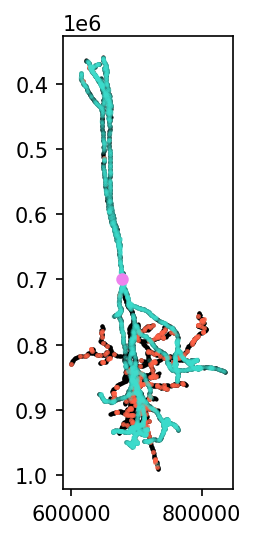

In [13]:
simple_neuron_plot(bpc_mw_2, synapses=True, highlight_root=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec">
<h3>Creating mask annotations</h3>   
In the pre-computed files, there are a number of annotations like `is_axon` that are useful for filtering the data.
Here's an example for how to generate one of those.

The <code>meshwork.algorithms</code> package has a few useful algorithms, including one that finds where to split axon and dendrite to optimally segregate synaptic inputs and outputs. We will use that to make our own `is_axon` annotation.


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec">
Q is a quality score, generally values above 0.7 are clear splits.

In [14]:
axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(bpc_mw_2, pre_anno='pre_syn', post_anno='post_syn')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec">

The easiest type of annotation to add is a 'mask' annotation, which just needs a name (here, "is_axon"), a list of mesh indices, and the argument `mask=True`.

In [15]:
bpc_mw_2.anno.add_annotations('is_axon', axon_inds, mask=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f1f6ec">

Now let's double check that this works by plotting the dendrite only. If it works, we should see only cyan inputs, and the part of the arbor with red dots will be masked out.

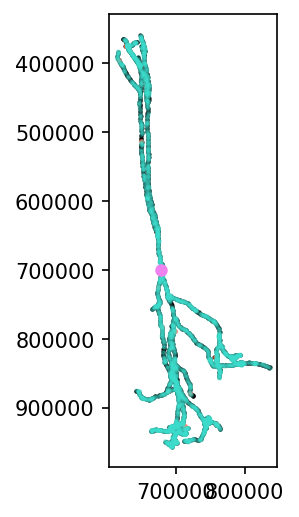

In [16]:
with bpc_mw_2.mask_context( ~bpc_mw_2.anno.is_axon.mesh_mask ):
    simple_neuron_plot(bpc_mw_2, synapses=True, highlight_root=True)

# TODO add deeper explanation of meshwork here 
- meshwork seamlessly links the mesh, skeleton, and annotations 
- the mesh is a collection of vertices (N,3) and faces (N,3) based upon trimesh (<a href="https://github.com/mikedh/trimesh"> https://github.com/mikedh/trimesh</a>), with some added features
- the skeleton is a stick-figure vertices and edges representation of the neuron. It is useful for computing metrics like shortest path between two points... (what else needs to be explained or would be a good example?)
- annotations are data linked to points on the mesh. You can create an annotation of anything and save it to the meshwork. 
- there is a map that goes from mesh nodes to skeleon nodes. Annotations can easily be transformed from mesh node space to skeleton node space with meshwork.annos.my_annotation.skel_index